# Prediction of Clusters of New Synapses

## I. Introduction

The goal of this project is to assign cluster labels to newly observed synapses by applying previously trained clustering models to their low-dimensional representations.

## II. Methodology

1. <u>Preprocessing and Standardization</u>:   
The 3D coordinates and morphological features of new synapses were processed using the same preprocessing pipeline as the historical dataset, including identical PCA models and scaling parameters to ensure full consistency.

2. <u>Dimensionality Reduction</u>:  
UMAP (Uniform Manifold Approximation and Projection) was used to embed the preprocessed data into the same 2D latent space as the training data, enabling reliable comparison and clustering.

3. <u>Prediction</u>:  
Pretrained, type-specific models were applied to the UMAP coordinates of new synapses to predict their cluster membership.
Outlier detection was performed using One-Class SVMs, assigning a cluster label of -1 to synapses identified as noise.


### II.1 Import the recquired libraries

In [136]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

sys.path.append(os.path.abspath('src'))
from prediction import apply_pca_robust_scaler, umap_model_syntype, umap_model_neurontype, predict_clusters

### II.2 Data loading

Load raw CSV dataset of new synapses

In [103]:
newsyn_df = pd.read_excel("new_neuron_synapse_raw_data.xlsx")

newsyn_df.head()

,NeuronId,SynType,SynId,x,y,z,soma_x,soma_y,soma_z,corr_x,...,corr_soma_z,SynArea,BoutonArea,BoutonVolume,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron
0,cb3,as,7,7694.17,2290.68,8250,4298.52,7796.4,350,7694.17,...,350,0.0927,1.8721,0.1398,7.69417,2.29068,8.250,4.29852,7.7964,0.35
1,cb3,ss,2,9123.59,4982.14,9275,4298.52,7796.4,350,9123.59,...,350,0.0654,0.9823,0.0735,9.12359,4.98214,9.275,4.29852,7.7964,0.35
2,cb3,ss,3,7140.28,2750.73,9800,4298.52,7796.4,350,7140.28,...,350,0.1111,3.7510,0.3126,7.14028,2.75073,9.800,4.29852,7.7964,0.35
3,cb3,as,8,8935.66,3025.19,9850,4298.52,7796.4,350,8935.66,...,350,0.0715,1.4379,0.0921,8.93566,3.02519,9.850,4.29852,7.7964,0.35
4,cb3,ss,4,7312.47,4420.33,10125,4298.52,7796.4,350,7312.47,...,350,0.0889,2.9250,0.2213,7.31247,4.42033,10.125,4.29852,7.7964,0.35


Display the datatypes

In [104]:
newsyn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NeuronId            30 non-null     object 
 1   SynType             30 non-null     object 
 2   SynId               30 non-null     int64  
 3   x                   30 non-null     float64
 4   y                   30 non-null     float64
 5   z                   30 non-null     int64  
 6   soma_x              30 non-null     float64
 7   soma_y              30 non-null     float64
 8   soma_z              30 non-null     int64  
 9   corr_x              30 non-null     float64
 10  corr_y              30 non-null     float64
 11  corr_z              30 non-null     int64  
 12  corr_soma_x         30 non-null     float64
 13  corr_soma_y         30 non-null     float64
 14  corr_soma_z         30 non-null     int64  
 15  SynArea             30 non-null     float64
 16  BoutonArea

### II.3 Data Preparation and Feature Engineering

creation of [NeuronType] column (additional label in order to separate the three neuron types)

In [105]:
conditions = [
    newsyn_df['NeuronId'].isin(['cb1', 'cb2', 'cb3']),  # Calbindin neurons
    newsyn_df['NeuronId'].isin(['cr1', 'cr2', 'cr3']),  # Calretinin neurons
    newsyn_df['NeuronId'].isin(['pv1', 'pv2', 'pv3'])   # Parvalbumin neurons
]

choices = [
    'calbindin',
    'calretinin',
    'parvalbumin'
]

newsyn_df['NeuronType'] = np.select(conditions, choices, default='other')

newsyn_df.head()

,NeuronId,SynType,SynId,x,y,z,soma_x,soma_y,soma_z,corr_x,...,SynArea,BoutonArea,BoutonVolume,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron,NeuronType
0,cb3,as,7,7694.17,2290.68,8250,4298.52,7796.4,350,7694.17,...,0.0927,1.8721,0.1398,7.69417,2.29068,8.250,4.29852,7.7964,0.35,calbindin
1,cb3,ss,2,9123.59,4982.14,9275,4298.52,7796.4,350,9123.59,...,0.0654,0.9823,0.0735,9.12359,4.98214,9.275,4.29852,7.7964,0.35,calbindin
2,cb3,ss,3,7140.28,2750.73,9800,4298.52,7796.4,350,7140.28,...,0.1111,3.7510,0.3126,7.14028,2.75073,9.800,4.29852,7.7964,0.35,calbindin
3,cb3,as,8,8935.66,3025.19,9850,4298.52,7796.4,350,8935.66,...,0.0715,1.4379,0.0921,8.93566,3.02519,9.850,4.29852,7.7964,0.35,calbindin
4,cb3,ss,4,7312.47,4420.33,10125,4298.52,7796.4,350,7312.47,...,0.0889,2.9250,0.2213,7.31247,4.42033,10.125,4.29852,7.7964,0.35,calbindin


**Spatial Coordinate Normalization**: Translation of synapse coordinates to a common origin (0, 0, 0)

In [106]:
df = newsyn_df.copy()

df["zero_corr_x"] = df["corr_x_micron"] - df["corr_soma_x_micron"]
df["zero_corr_y"] = df["corr_y_micron"] - df["corr_soma_y_micron"]
df["zero_corr_z"] = df["corr_z_micron"] - df["corr_soma_z_micron"]

df.head(5)

,NeuronId,SynType,SynId,x,y,z,soma_x,soma_y,soma_z,corr_x,...,corr_x_micron,corr_y_micron,corr_z_micron,corr_soma_x_micron,corr_soma_y_micron,corr_soma_z_micron,NeuronType,zero_corr_x,zero_corr_y,zero_corr_z
0,cb3,as,7,7694.17,2290.68,8250,4298.52,7796.4,350,7694.17,...,7.69417,2.29068,8.250,4.29852,7.7964,0.35,calbindin,3.39565,-5.50572,7.900
1,cb3,ss,2,9123.59,4982.14,9275,4298.52,7796.4,350,9123.59,...,9.12359,4.98214,9.275,4.29852,7.7964,0.35,calbindin,4.82507,-2.81426,8.925
2,cb3,ss,3,7140.28,2750.73,9800,4298.52,7796.4,350,7140.28,...,7.14028,2.75073,9.800,4.29852,7.7964,0.35,calbindin,2.84176,-5.04567,9.450
3,cb3,as,8,8935.66,3025.19,9850,4298.52,7796.4,350,8935.66,...,8.93566,3.02519,9.850,4.29852,7.7964,0.35,calbindin,4.63714,-4.77121,9.500
4,cb3,ss,4,7312.47,4420.33,10125,4298.52,7796.4,350,7312.47,...,7.31247,4.42033,10.125,4.29852,7.7964,0.35,calbindin,3.01395,-3.37607,9.775


Selection of relevant spatial and morphometric features

In [107]:
newsyn_df_final=df[['NeuronType', 'NeuronId', 'SynType', 'SynId', 'zero_corr_x', 'zero_corr_y', 'zero_corr_z', 'SynArea', 'BoutonArea', 'BoutonVolume']]

newsyn_df_final.head(5)

,NeuronType,NeuronId,SynType,SynId,zero_corr_x,zero_corr_y,zero_corr_z,SynArea,BoutonArea,BoutonVolume
0,calbindin,cb3,as,7,3.39565,-5.50572,7.900,0.0927,1.8721,0.1398
1,calbindin,cb3,ss,2,4.82507,-2.81426,8.925,0.0654,0.9823,0.0735
2,calbindin,cb3,ss,3,2.84176,-5.04567,9.450,0.1111,3.7510,0.3126
3,calbindin,cb3,as,8,4.63714,-4.77121,9.500,0.0715,1.4379,0.0921
4,calbindin,cb3,ss,4,3.01395,-3.37607,9.775,0.0889,2.9250,0.2213


In [108]:
newsyn_df_final.SynType.value_counts().sort_index()

SynType
as    20
ss    10
Name: count, dtype: int64

In [109]:
newsyn_df_final.NeuronId.value_counts().sort_index()

NeuronId
cb3    10
cr2    10
pv1    10
Name: count, dtype: int64

In [110]:
newsyn_df_final.NeuronType.value_counts().sort_index()

NeuronType
calbindin      10
calretinin     10
parvalbumin    10
Name: count, dtype: int64

### II.4 Morphometric Feature Cleaning and Outlier Filtering

Identification of extreme outliers in morphometric features

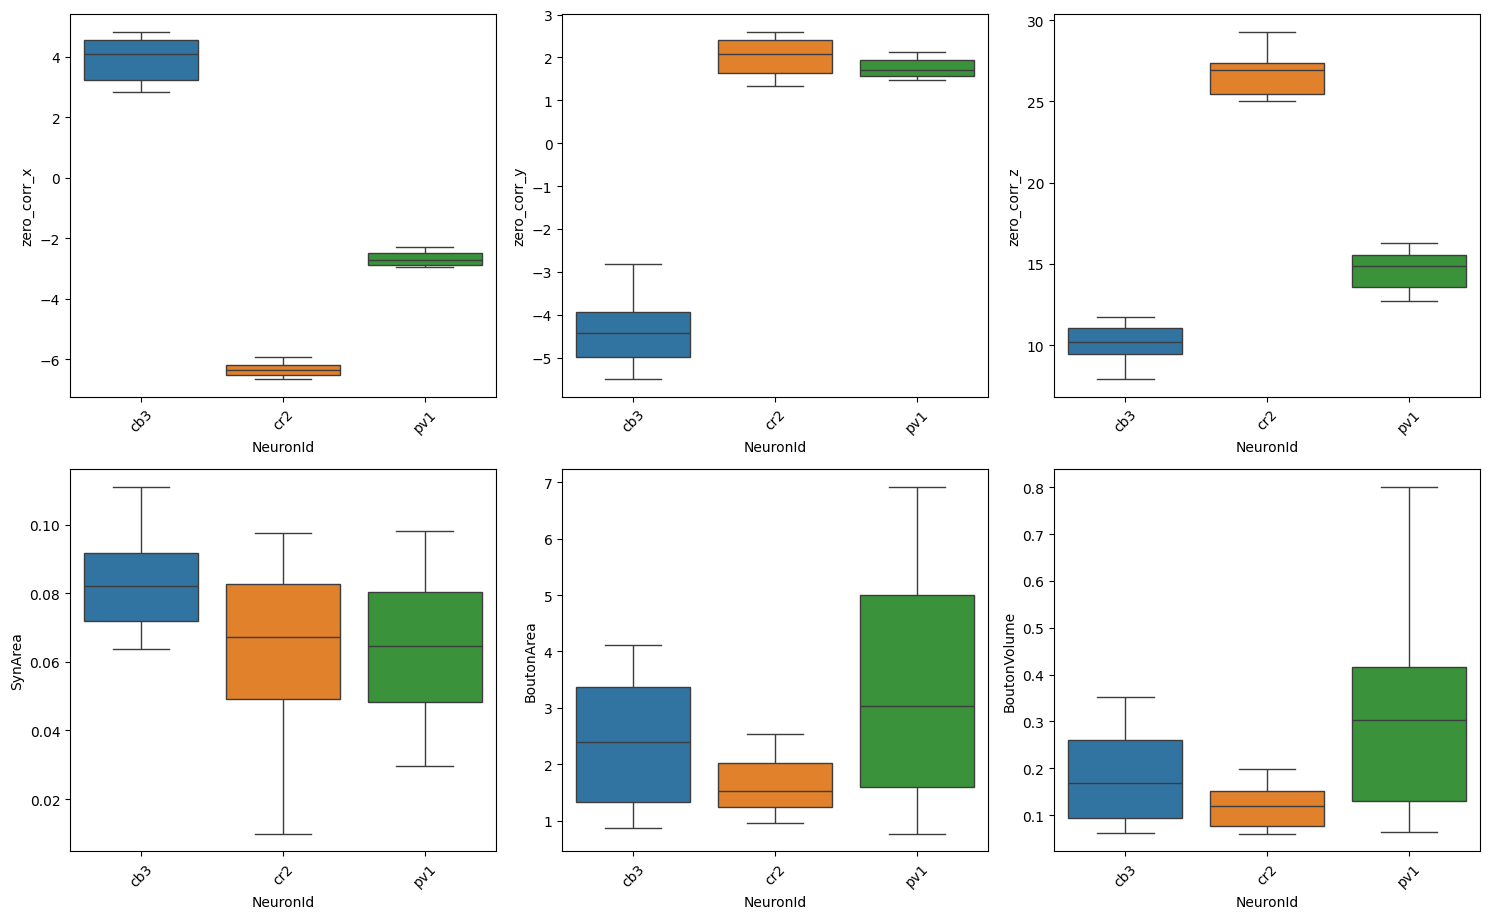

In [111]:
sns.set_context('notebook')
plt.style.use('default')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns_to_box = ['zero_corr_x', 'zero_corr_y', 'zero_corr_z',
                  'SynArea', 'BoutonArea', 'BoutonVolume']

neuron_order = ['cb3', 'cr2','pv1']
base_palette = sns.color_palette('tab10', len(neuron_order))
NEURON_COLORS = dict(zip(neuron_order, base_palette))

neuron_ids = sorted(newsyn_df_final['NeuronId'].unique())
palette = sns.color_palette('tab10', len(neuron_ids))
color_map = dict(zip(neuron_ids, palette))   

for ax, col in zip(axes, columns_to_box):
    sns.boxplot(
        data=newsyn_df_final,
        x='NeuronId',     
        y=col,
        hue='NeuronId',   
        ax=ax,
        order=neuron_order,
        palette=NEURON_COLORS,
        legend=False      
    )
    # ax.set_title(col, fontsize=12)
    ax.set_xlabel('NeuronId')
    ax.tick_params(axis='x', rotation=45)

fig.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()

Extreme outliers have not been found in this dataset.

**Optional step**: Removing of extreme outliers in morphometric features

In [112]:
columns_to_check = ['SynArea', 'BoutonArea']

extreme_outlier_indices = set()

df_temp = newsyn_df_final.copy()

for col in columns_to_check:
    # IQR calculation
    Q1 = df_temp[col].quantile(0.25)
    Q3 = df_temp[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Extreme outlier thresholds (3 * IQR rule)
    lower_bound_extreme = Q1 - 3 * IQR
    upper_bound_extreme = Q3 + 3 * IQR
    
    # Find indices of extreme outliers
    outlier_rows = df_temp[
        (df_temp[col] < lower_bound_extreme) | 
        (df_temp[col] > upper_bound_extreme)
    ]
    
    # Add indices to the set
    extreme_outlier_indices.update(outlier_rows.index)

# Create the neuron_df_filtered DataFrame: remove the collected indices
# The ~ (tilde) operator inverts the selection (select rows that are NOT outliers)
neuron_df_filtered = df_temp.drop(index=list(extreme_outlier_indices))

removed_count = len(newsyn_df_final) - len(neuron_df_filtered)
print(f"Original count: {len(newsyn_df_final)}")
print(f"Removed entries (SynArea/BoutonArea extreme outliers): {removed_count}")
print(f"Filtered count (neuron_df_filtered): {len(neuron_df_filtered)}")

Original count: 30
Removed entries (SynArea/BoutonArea extreme outliers): 0
Filtered count (neuron_df_filtered): 30


### II.5 Prepocessing and Embedding of New Synapses

The new dataset was processed using the same PCA and robust scaling pipeline as the training data and embedded into the trained UMAP manifolds using previously saved UMAP models.

In [137]:
df_scaled = apply_pca_robust_scaler(newsyn_df_final)
df_syn_umap = umap_model_syntype(df_scaled)
df_neuron_umap = umap_model_neurontype(df_scaled)

In [138]:
df_syn_umap

,NeuronType,NeuronId,SynType,SynId,zero_corr_x,zero_corr_y,zero_corr_z,SynArea,BoutonArea,BoutonVolume,pca_x,pca_y,pca_z,pca_x_scaled,pca_y_scaled,pca_z_scaled,SynArea_scaled,BoutonArea_scaled,UMAP_1,UMAP_2
0,calbindin,cb3,as,7,3.39565,-5.50572,7.900,0.0927,1.8721,0.1398,-1.518546,-1.823241,-1.020115,-0.045425,-1.080713,-1.396441,1.361670,0.581590,8.144069,9.340645
1,calbindin,cb3,ss,2,4.82507,-2.81426,8.925,0.0654,0.9823,0.0735,-1.838038,1.133965,0.200820,-0.068776,0.679564,0.339536,0.583484,-0.305138,6.457627,0.079549
2,calbindin,cb3,ss,3,2.84176,-5.04567,9.450,0.1111,3.7510,0.3126,-0.239673,-1.436936,0.045807,0.048047,-0.850765,0.119133,1.886162,2.454003,5.666174,1.778445
3,calbindin,cb3,as,8,4.63714,-4.77121,9.500,0.0715,1.4379,0.0921,-0.500199,0.073009,-0.930619,0.029006,0.048030,-1.269192,0.757364,0.148889,8.160730,9.358788
4,calbindin,cb3,ss,4,3.01395,-3.37607,9.775,0.0889,2.9250,0.2213,-0.642525,-0.241368,1.199568,0.018603,-0.139102,1.759598,1.253351,1.630855,5.681178,0.732537
5,calbindin,cb3,as,9,4.60059,-4.67596,10.650,0.0638,0.8694,0.0625,0.508214,0.497359,-0.561922,0.102710,0.300625,-0.744963,0.537876,-0.417648,7.975316,9.640580
6,calbindin,cb3,as,10,3.78153,-3.84562,10.700,0.0962,3.3881,0.2740,0.304487,0.380372,0.581596,0.087820,0.230988,0.880939,1.461437,2.092356,7.280821,6.797103
7,calbindin,cb3,as,11,3.18980,-5.10828,11.175,0.0794,1.2956,0.1017,1.312930,-0.618273,0.186844,0.161526,-0.363456,0.319665,0.982554,0.007080,8.358049,9.388059
8,calbindin,cb3,as,12,4.43238,-4.19674,11.725,0.0851,4.1123,0.3518,1.306675,1.017557,0.149011,0.161069,0.610273,0.265872,1.145032,2.814056,6.841139,5.862853
9,calbindin,cb3,ss,5,4.43238,-4.19674,11.725,0.0732,3.2850,0.1965,1.306675,1.017557,0.149011,0.161069,0.610273,0.265872,0.805823,1.989612,5.734442,0.932299


In [139]:
df_neuron_umap

,NeuronType,NeuronId,SynType,SynId,zero_corr_x,zero_corr_y,zero_corr_z,SynArea,BoutonArea,BoutonVolume,pca_x,pca_y,pca_z,pca_x_scaled,pca_y_scaled,pca_z_scaled,SynArea_scaled,BoutonArea_scaled,UMAP_1,UMAP_2
0,calbindin,cb3,as,7,3.39565,-5.50572,7.900,0.0927,1.8721,0.1398,-1.518546,-1.823241,-1.020115,-0.045425,-1.080713,-1.396441,1.361670,0.581590,17.047930,6.590975
1,calbindin,cb3,ss,2,4.82507,-2.81426,8.925,0.0654,0.9823,0.0735,-1.838038,1.133965,0.200820,-0.068776,0.679564,0.339536,0.583484,-0.305138,17.078077,6.355891
2,calbindin,cb3,ss,3,2.84176,-5.04567,9.450,0.1111,3.7510,0.3126,-0.239673,-1.436936,0.045807,0.048047,-0.850765,0.119133,1.886162,2.454003,17.309635,7.876895
3,calbindin,cb3,as,8,4.63714,-4.77121,9.500,0.0715,1.4379,0.0921,-0.500199,0.073009,-0.930619,0.029006,0.048030,-1.269192,0.757364,0.148889,17.343164,6.509929
4,calbindin,cb3,ss,4,3.01395,-3.37607,9.775,0.0889,2.9250,0.2213,-0.642525,-0.241368,1.199568,0.018603,-0.139102,1.759598,1.253351,1.630855,17.298349,7.374989
5,calbindin,cb3,as,9,4.60059,-4.67596,10.650,0.0638,0.8694,0.0625,0.508214,0.497359,-0.561922,0.102710,0.300625,-0.744963,0.537876,-0.417648,17.369022,6.519496
6,calbindin,cb3,as,10,3.78153,-3.84562,10.700,0.0962,3.3881,0.2740,0.304487,0.380372,0.581596,0.087820,0.230988,0.880939,1.461437,2.092356,17.654423,7.712587
7,calbindin,cb3,as,11,3.18980,-5.10828,11.175,0.0794,1.2956,0.1017,1.312930,-0.618273,0.186844,0.161526,-0.363456,0.319665,0.982554,0.007080,17.357561,6.519394
8,calbindin,cb3,as,12,4.43238,-4.19674,11.725,0.0851,4.1123,0.3518,1.306675,1.017557,0.149011,0.161069,0.610273,0.265872,1.145032,2.814056,17.546839,8.696741
9,calbindin,cb3,ss,5,4.43238,-4.19674,11.725,0.0732,3.2850,0.1965,1.306675,1.017557,0.149011,0.161069,0.610273,0.265872,0.805823,1.989612,17.687189,7.814250


### II.6 Prediction of Clusters of New Synapses

Previously trained and saved models are applied to the UMAP coordinates of new synapses to predict cluster membership.
The same preprocessing steps used during training (scaling and outlier detection) are reused, and synapses identified as outliers are assigned to the noise class. (see prediction.py)

#### II.6.1 **Excitatory ('as') synapses**

In [140]:
df_as_prediction = (
    df_syn_umap
    .loc[df_syn_umap['SynType'] == 'as',
         ['NeuronType', 'NeuronId', 'SynType', 'SynId', 'UMAP_1', 'UMAP_2']]
    .copy()
)

In [141]:
df_as_prediction.head()

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2
0,calbindin,cb3,as,7,8.144069,9.340645
3,calbindin,cb3,as,8,8.160730,9.358788
5,calbindin,cb3,as,9,7.975316,9.640580
6,calbindin,cb3,as,10,7.280821,6.797103
7,calbindin,cb3,as,11,8.358049,9.388059


In [142]:
df_as_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 28
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NeuronType  20 non-null     object 
 1   NeuronId    20 non-null     object 
 2   SynType     20 non-null     object 
 3   SynId       20 non-null     int64  
 4   UMAP_1      20 non-null     float32
 5   UMAP_2      20 non-null     float32
dtypes: float32(2), int64(1), object(3)
memory usage: 960.0+ bytes


In [143]:
bundle = joblib.load("as_xgb_bundle.pkl")

X = df_as_prediction[["UMAP_1", "UMAP_2"]].values
X_scaled = bundle["scaler"].transform(X)

clusters = np.full(len(X), -1, dtype=int)

inlier_mask = (bundle["ocsvm"].predict(X_scaled) == 1)

pred_enc = bundle["model"].predict(X_scaled[inlier_mask])
pred_dec = bundle["label_encoder"].inverse_transform(pred_enc)

clusters[inlier_mask] = pred_dec.astype(int)

df_as_prediction = df_as_prediction.copy()
df_as_prediction["Cluster"] = clusters

print("Final clusters:", np.unique(df_as_prediction["Cluster"]))

Final clusters: [-1  2  4]


In [144]:
df_as_prediction

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2,Cluster
0,calbindin,cb3,as,7,8.144069,9.340645,-1
3,calbindin,cb3,as,8,8.160730,9.358788,-1
5,calbindin,cb3,as,9,7.975316,9.640580,4
6,calbindin,cb3,as,10,7.280821,6.797103,-1
7,calbindin,cb3,as,11,8.358049,9.388059,-1
8,calbindin,cb3,as,12,6.841139,5.862853,2
10,calretinin,cr2,as,47,7.791811,9.794424,4
11,calretinin,cr2,as,48,9.150911,7.854050,2
12,calretinin,cr2,as,49,9.225997,8.034836,2
13,calretinin,cr2,as,50,8.075788,9.608318,-1


#### II.6.2 **Inhibitory ('ss') synapses**

In [145]:
df_ss_prediction = (
    df_syn_umap
    .loc[df_syn_umap['SynType'] == 'ss',
         ['NeuronType', 'NeuronId', 'SynType', 'SynId', 'UMAP_1', 'UMAP_2']]
    .copy()
)

In [146]:
df_ss_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 1 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   NeuronType  10 non-null     object 
 1   NeuronId    10 non-null     object 
 2   SynType     10 non-null     object 
 3   SynId       10 non-null     int64  
 4   UMAP_1      10 non-null     float32
 5   UMAP_2      10 non-null     float32
dtypes: float32(2), int64(1), object(3)
memory usage: 480.0+ bytes


In [147]:
bundle = joblib.load("ss_xgb_bundle.pkl")

X = df_ss_prediction[["UMAP_1", "UMAP_2"]].values
X_scaled = bundle["scaler"].transform(X)

clusters = np.full(len(X), -1, dtype=int)

inlier_mask = (bundle["ocsvm"].predict(X_scaled) == 1)

pred_enc = bundle["model"].predict(X_scaled[inlier_mask])
pred_dec = bundle["label_encoder"].inverse_transform(pred_enc)

clusters[inlier_mask] = pred_dec.astype(int)

df_ss_prediction = df_ss_prediction.copy()
df_ss_prediction["Cluster"] = clusters

print("Final clusters:", np.unique(df_ss_prediction["Cluster"]))

Final clusters: [-1  2]


In [148]:
df_ss_prediction

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2,Cluster
1,calbindin,cb3,ss,2,6.457627,0.079549,-1
2,calbindin,cb3,ss,3,5.666174,1.778445,2
4,calbindin,cb3,ss,4,5.681178,0.732537,2
9,calbindin,cb3,ss,5,5.734442,0.932299,2
14,calretinin,cr2,ss,5,6.136287,0.541704,2
15,calretinin,cr2,ss,6,6.460824,0.072625,-1
18,calretinin,cr2,ss,7,6.414618,0.139055,-1
25,parvalbumin,pv1,ss,22,6.664526,-0.054136,-1
27,parvalbumin,pv1,ss,23,6.679504,0.025725,-1
29,parvalbumin,pv1,ss,24,4.531856,3.910536,-1


#### II.6.3 **Calbindin ('cb') synapses**

In [149]:
df_cb_prediction = (
    df_neuron_umap
    .loc[df_neuron_umap['NeuronType'] == 'calbindin',
         ['NeuronType', 'NeuronId', 'SynType', 'SynId', 'UMAP_1', 'UMAP_2']]
    .copy()
)

In [150]:
bundle = joblib.load("cb_xgb_bundle.pkl")

X = df_cb_prediction[["UMAP_1", "UMAP_2"]].values
X_scaled = bundle["scaler"].transform(X)

clusters = np.full(len(X), -1, dtype=int)

inlier_mask = (bundle["ocsvm"].predict(X_scaled) == 1)

pred_enc = bundle["model"].predict(X_scaled[inlier_mask])
pred_dec = bundle["label_encoder"].inverse_transform(pred_enc)

clusters[inlier_mask] = pred_dec.astype(int)

df_cb_prediction = df_cb_prediction.copy()
df_cb_prediction["Cluster"] = clusters

print("Final clusters:", np.unique(df_cb_prediction["Cluster"]))

Final clusters: [-1  1]


In [151]:
df_cb_prediction

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2,Cluster
0,calbindin,cb3,as,7,17.047930,6.590975,1
1,calbindin,cb3,ss,2,17.078077,6.355891,1
2,calbindin,cb3,ss,3,17.309635,7.876895,1
3,calbindin,cb3,as,8,17.343164,6.509929,1
4,calbindin,cb3,ss,4,17.298349,7.374989,1
5,calbindin,cb3,as,9,17.369022,6.519496,1
6,calbindin,cb3,as,10,17.654423,7.712587,1
7,calbindin,cb3,as,11,17.357561,6.519394,1
8,calbindin,cb3,as,12,17.546839,8.696741,-1
9,calbindin,cb3,ss,5,17.687189,7.814250,1


#### II.6.4 **Calretinin ('cr') synapses**

In [152]:
df_cr_prediction = (
    df_neuron_umap
    .loc[df_neuron_umap['NeuronType'] == 'calretinin',
         ['NeuronType', 'NeuronId', 'SynType', 'SynId', 'UMAP_1', 'UMAP_2']]
    .copy()
)

In [153]:
bundle = joblib.load("cr_knn_bundle.pkl")

X = df_cr_prediction[["UMAP_1", "UMAP_2"]].values
X_scaled = bundle["scaler"].transform(X) if "scaler" in bundle else X

clusters = bundle["model"].predict(X_scaled).astype(int)

df_cr_prediction = df_cr_prediction.copy()
df_cr_prediction["Cluster"] = clusters

print("Final CR clusters:", np.unique(df_cr_prediction["Cluster"]))

Final CR clusters: [-1]


In [154]:
df_cr_prediction

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2,Cluster
10,calretinin,cr2,as,47,-6.709768,-1.716215,-1
11,calretinin,cr2,as,48,-6.383964,-0.504228,-1
12,calretinin,cr2,as,49,-6.478292,-0.840924,-1
13,calretinin,cr2,as,50,-6.790212,-1.356599,-1
14,calretinin,cr2,ss,5,-5.957767,-0.309162,-1
15,calretinin,cr2,ss,6,-6.796928,-1.112489,-1
16,calretinin,cr2,as,51,-6.673851,-2.021483,-1
17,calretinin,cr2,as,52,-6.046324,-0.241600,-1
18,calretinin,cr2,ss,7,-6.663705,-0.406102,-1
19,calretinin,cr2,as,53,-6.691902,1.096861,-1


* Although preliminary tests showed that KNN performed best on calretinin data, it proved to be overly restrictive during prediction, classifying all new synapses as outliers.
* Therefore, tree-based Random Forest provides a more robust and generalizable solution for calretinin synapses.

In [155]:
bundle = joblib.load("cr_rf_bundle.pkl")

X = df_cr_prediction[["UMAP_1", "UMAP_2"]].values
X_scaled = bundle["scaler"].transform(X)

clusters = np.full(len(X), -1, dtype=int)

inlier_mask = (bundle["ocsvm"].predict(X_scaled) == 1)

clusters[inlier_mask] = bundle["model"].predict(
    X_scaled[inlier_mask]
).astype(int)

df_cr_prediction = df_cr_prediction.copy()
df_cr_prediction["Cluster"] = clusters

print("Final clusters:", np.unique(df_cr_prediction["Cluster"]))

Final clusters: [-1  5]


Result of random forest prediction

In [156]:
df_cr_prediction

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2,Cluster
10,calretinin,cr2,as,47,-6.709768,-1.716215,-1
11,calretinin,cr2,as,48,-6.383964,-0.504228,-1
12,calretinin,cr2,as,49,-6.478292,-0.840924,-1
13,calretinin,cr2,as,50,-6.790212,-1.356599,-1
14,calretinin,cr2,ss,5,-5.957767,-0.309162,5
15,calretinin,cr2,ss,6,-6.796928,-1.112489,-1
16,calretinin,cr2,as,51,-6.673851,-2.021483,-1
17,calretinin,cr2,as,52,-6.046324,-0.241600,5
18,calretinin,cr2,ss,7,-6.663705,-0.406102,-1
19,calretinin,cr2,as,53,-6.691902,1.096861,-1


#### II.6.5 **Parvalbumin ('pv') synapses**

In [157]:
df_pv_prediction = (
    df_neuron_umap
    .loc[df_neuron_umap['NeuronType'] == 'parvalbumin',
         ['NeuronType', 'NeuronId', 'SynType', 'SynId', 'UMAP_1', 'UMAP_2']]
    .copy()
)

In [158]:
bundle = joblib.load("pv_xgb_bundle.pkl")

X = df_pv_prediction[["UMAP_1", "UMAP_2"]].values
X_scaled = bundle["scaler"].transform(X)

clusters = np.full(len(X), -1, dtype=int)

inlier_mask = (bundle["ocsvm"].predict(X_scaled) == 1)

pred_enc = bundle["model"].predict(X_scaled[inlier_mask])
pred_dec = bundle["label_encoder"].inverse_transform(pred_enc)

clusters[inlier_mask] = pred_dec.astype(int)

df_pv_prediction = df_pv_prediction.copy()
df_pv_prediction["Cluster"] = clusters

print("Final clusters:", np.unique(df_pv_prediction["Cluster"]))

Final clusters: [2]


In [159]:
df_pv_prediction

,NeuronType,NeuronId,SynType,SynId,UMAP_1,UMAP_2,Cluster
20,parvalbumin,pv1,as,50,-0.706223,5.580664,2
21,parvalbumin,pv1,as,51,1.268700,4.891621,2
22,parvalbumin,pv1,as,52,3.326143,3.603186,2
23,parvalbumin,pv1,as,53,-1.231608,4.424223,2
24,parvalbumin,pv1,as,54,2.732877,3.566878,2
25,parvalbumin,pv1,ss,22,-1.395200,4.309751,2
26,parvalbumin,pv1,as,55,0.374746,5.026244,2
27,parvalbumin,pv1,ss,23,-1.505406,4.307935,2
28,parvalbumin,pv1,as,56,3.088299,3.649965,2
29,parvalbumin,pv1,ss,24,3.175240,3.515247,2


## III. Final Conclusion

The trained models and the presented preprocessing and prediction pipeline are suitable for assigning new synapses to previously identified clusters in UMAP space, while explicitly handling outliers and preserving consistency with the historical training data.